In [47]:
import pandas as pd
from sklearn import preprocessing
import xgboost as xg
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz 
import warnings
import numpy as np
import sqlite3
import json
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import joblib
from joblib import dump, load
%matplotlib inline


warnings.filterwarnings('ignore')

In [48]:
df = pd.read_csv('csvs/encuestas.csv')

In [49]:
cand_data = json.loads(open('predictor_pol/candidatos.json','r').read())

In [50]:
def get_party(id):
    for p in cand_data:
        for c in p['candidates']:
            if c['id'] == id:
                return p['party']
    return 'n/a'

def get_name(id):
    for p in cand_data:
        for c in p['candidates']:
            if c['id'] == id:
                return c['name']
    return 'n/a'

In [51]:
df['partido'] = df.candidato.apply(get_party)
df['nombre'] = df.candidato.apply(get_name)

In [52]:
print("cantidad de registros: {}".format(len(df)))

cantidad de registros: 19153


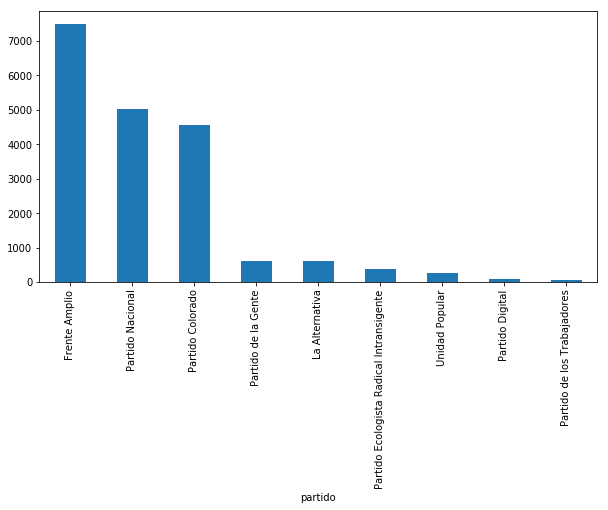

In [53]:
plt.rcParams['figure.figsize'] = [10, 5]
df.groupby('partido').size().sort_values(ascending=False).plot.bar()

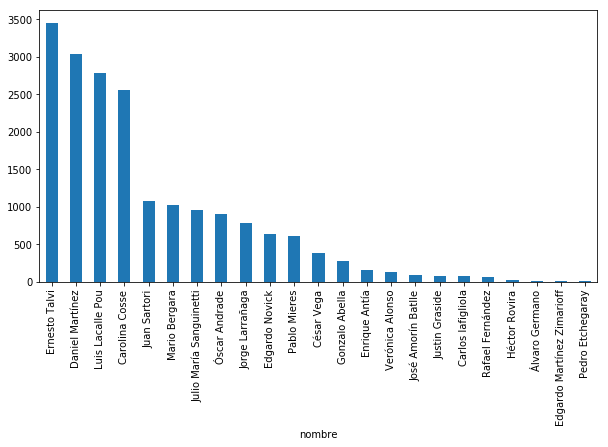

In [54]:
df.groupby('nombre').size().sort_values(ascending=False).plot.bar()

In [55]:
df.head()

,id,candidato,fecha,partido,nombre
0,30,16,2019-02-03T16:13:13.649130,Partido Colorado,Julio María Sanguinetti
1,31,9,2019-02-04T22:14:04.368663,Partido Nacional,Luis Lacalle Pou
2,32,4,2019-02-05T13:03:33.624680,Frente Amplio,Daniel Martínez
3,33,19,2019-02-05T16:06:41.040221,Unidad Popular,Gonzalo Abella
4,34,18,2019-02-05T16:39:54.482634,La Alternativa,Pablo Mieres


In [56]:
respuestas = pd.read_csv('csvs/respuestas_encuestas.csv')

In [57]:
def resp(id_encuesta,id_pregunta):
    s= respuestas[(respuestas['id_encuesta'] == id_encuesta) & (respuestas['id_pregunta'] == id_pregunta)]['respuesta']
    return s.get_values()[0]

In [58]:
for i in range(1,27):
    df['resp_{}'.format(i)] = df.id.apply(lambda x: resp(x,i))
features = []
for i in range(1,27):
    features.append('resp_{}'.format(i))

In [140]:
from sklearn.linear_model import LogisticRegression

#Split train and test
df_train, df_test = train_test_split(df, test_size=0.20)

In [146]:
# Try to predict candidate
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=700).fit(df_train[features], df_train.candidato)
df_test['predicted_candidate'] = clf.predict(df_test[features])

df_test['predicted_candidate'] = df_test['predicted_candidate'].apply(get_name)
df_test['candidato'] = df_test['candidato'].apply(get_name)
print(classification_report(df_test.candidato,df_test.predicted_candidate))

                            precision    recall  f1-score   support

         Carlos Iafigliola       0.17      0.05      0.08        20
            Carolina Cosse       0.41      0.48      0.44       521
                César Vega       0.14      0.03      0.05        61
           Daniel Martínez       0.39      0.63      0.48       588
Edgardo Martínez Zimarioff       0.00      0.00      0.00         2
            Edgardo Novick       0.13      0.02      0.03       133
             Enrique Antía       0.00      0.00      0.00        35
             Ernesto Talvi       0.37      0.62      0.47       694
            Gonzalo Abella       0.69      0.16      0.26        56
             Héctor Rovira       0.00      0.00      0.00         6
           Jorge Larrañaga       0.44      0.03      0.05       155
        José Amorín Batlle       0.00      0.00      0.00        26
              Juan Sartori       0.20      0.01      0.02       241
   Julio María Sanguinetti       0.17      0.01

In [147]:
# Try to predict party
clf_party = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=700).fit(df_train[features], df_train.partido)
df_test['predicted_party'] = clf_party.predict(df_test[features])
print(classification_report(df_test.partido,df_test.predicted_party))

                                          precision    recall  f1-score   support

                           Frente Amplio       0.78      0.92      0.85      1478
                          La Alternativa       0.00      0.00      0.00       136
                        Partido Colorado       0.50      0.48      0.49       906
                         Partido Digital       0.00      0.00      0.00        18
Partido Ecologista Radical Intransigente       0.33      0.02      0.03        61
                        Partido Nacional       0.54      0.64      0.59      1030
                     Partido de la Gente       0.00      0.00      0.00       133
             Partido de los Trabajadores       0.00      0.00      0.00        13
                          Unidad Popular       0.86      0.11      0.19        56

                             avg / total       0.58      0.64      0.60      3831



In [148]:
df_test[['predicted_candidate','predicted_party','nombre','partido']].head()


,predicted_candidate,predicted_party,nombre,partido
17525,Rafael Fernández,Partido de los Trabajadores,Luis Lacalle Pou,Partido Nacional
12665,Daniel Martínez,Frente Amplio,Daniel Martínez,Frente Amplio
992,Ernesto Talvi,Partido Colorado,Julio María Sanguinetti,Partido Colorado
13953,Daniel Martínez,Frente Amplio,Mario Bergara,Frente Amplio
9819,Ernesto Talvi,Partido Nacional,Ernesto Talvi,Partido Colorado


# Ahora probamos KNeighborsClassifier

In [157]:
n=22
k=22

pca = PCA(n_components=n)
pca.fit(df[features])
X = pca.transform(df[features])
y = df.candidato
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
candidate_model = KNeighborsClassifier(n_neighbors=n)
candidate_model.fit(X_train, y_train)
results = pd.DataFrame()
results['truth'] = y_test
results['truth'] = results.truth.apply(get_name)
results['prediction'] = candidate_model.predict(X_test)
results['prediction'] = results.prediction.apply(get_name)

print(classification_report(results.truth,results.prediction ))

                            precision    recall  f1-score   support

         Carlos Iafigliola       0.00      0.00      0.00        22
            Carolina Cosse       0.41      0.44      0.43       521
                César Vega       0.00      0.00      0.00        65
           Daniel Martínez       0.38      0.54      0.44       584
Edgardo Martínez Zimarioff       0.00      0.00      0.00         3
            Edgardo Novick       0.10      0.01      0.01       137
             Enrique Antía       0.00      0.00      0.00        29
             Ernesto Talvi       0.34      0.59      0.43       682
            Gonzalo Abella       0.50      0.05      0.09        59
             Héctor Rovira       0.00      0.00      0.00         3
           Jorge Larrañaga       0.17      0.01      0.02       165
        José Amorín Batlle       0.00      0.00      0.00        15
              Juan Sartori       0.08      0.02      0.03       233
   Julio María Sanguinetti       0.09      0.01

In [158]:
#exporto modelos
joblib.dump(clf, 'predictor_pol/candidate_model_2.joblib')

['predictor_pol/candidate_model_2.joblib']

In [159]:

pcax = joblib.load('predictor_pol/pca.joblib')

d={'resp_21': ['1'], 'resp_1': ['1'], 
   'resp_23': ['1'], 'resp_24': ['1'], 'resp_11': ['1'], 
   'resp_9': ['1'], 'resp_13': ['1'], 'resp_14': ['1'], 
   'resp_10': ['1'], 'resp_22': ['1'], 'resp_5': ['1'], 'resp_16': ['1'], 
   'resp_3': ['1'], 'resp_18': ['1'], 'resp_2': ['1'], 'resp_8': ['1'], 
   'resp_12': ['1'], 'resp_19': ['1'], 'resp_17': ['1'], 'resp_26': ['1'], 
   'resp_20': ['1'], 'resp_4': ['1'], 'resp_25': ['1'], 'resp_15': ['1'], 'resp_6': ['1'], 'resp_7': ['1']}
foo = pd.DataFrame.from_dict(d)

In [160]:
bar = pcax.transform(foo)

In [161]:
bar#-5.5,4.68

array([[-5.13262373,  4.31733299,  3.25014081,  3.09118577, -6.16949072,
        -0.5597754 ,  0.93137995,  1.64598914,  1.67812135,  1.41794857,
        -0.88216376, -1.68551561,  0.99353496, -0.56807533,  1.86410674,
        -1.59868127, -0.62187692]])

In [166]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train ,feature_names = features)

In [167]:
exp = explainer.explain_instance(df_test[[features]][0], clf.predict_proba, num_features=2, top_labels=1)

TypeError: unhashable type: 'list'